# DPU : Resnet50 trained on Tipu12
----

## 0. Extract dataset
We extract the dataset if needed

In [1]:
import tarfile
import os

# Define the file paths
tar_xz_file = 'test_tipu12.tar.xz'
extract_path = 'tipu12'

# Extract the tar.xz file
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    
    with tarfile.open(tar_xz_file, 'r:xz') as tar:
        tar.extractall(path=extract_path)
    print(f'Files extracted to path: {extract_path}')
else:
    print(f'Files already exist in path: {extract_path}')

Files already exist in path: tipu12


## 1. Prepare the overlay
We will download the overlay onto the board. 

In [2]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [3]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART. It takes the `.xmodel` in argument.

In [4]:
overlay.load_model("kv260_tipu12.xmodel")

We first define our preprocessing functions. These functions need to be the same ones as used for traing the model.

In [44]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image, image_path, crop_height = 224, crop_width = 224):
    if image is None:
        raise ValueError(f"Error reading image at {image_path}")
    image = resize_shortest_edge(image, 256)
    #image = mean_image_subtraction(image, MEANS)
    image = central_crop(image, crop_height, crop_width)
    image = BGR2RGB(image)
    image = normalize(image)
    return image

We will also define a few functions to calculate softmax and provide 
the output class after running a DPU task.

In [45]:
class_file = "tipu12_class_to_order.txt"

def calculate_softmax(data):
    e_x = np.exp(data - np.max(data))
    return e_x / e_x.sum()

def predict_label(softmax):
    with open(class_file, "r") as f:
        lines = f.readlines()
        lines = [item.strip() for item in lines]
        class_arg = np.argmax(softmax)
        class_name = lines[class_arg]
    return class_name, class_arg

## 3. Use VART
Now we should be able to use VART to do image classification.

In [46]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

In [47]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [52]:
from collections import OrderedDict

def count_total_images(dataset_folder):
    total = 0
    for class_folder in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

def is_image_file(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    ext = os.path.splitext(file_path)[-1].lower()
    return ext in valid_extensions

predictions_list = []
label_names_list = []
class_accuracy = []
accuracy = []

def calculate_accuracy(dpu, input_data, output_data, image_folder):
    correct = 0
    total = count_total_images(image_folder)
    print(f"Total number of images in dataset: {total}")
    
    class_correct = {}
    class_total = {}
    
    time1 = time.time()
    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        class_label = class_folder
        class_images = os.listdir(class_path)
        
        # Initialize class counters
        if class_label not in class_correct:
            class_correct[class_label] = 0
            class_total[class_label] = 0

        for image_name in class_images:
            image_path = os.path.join(class_path, image_name)

            # Skip non-image files (e.g., .ipynb_checkpoints)
            if not is_image_file(image_path):
                continue

            # Preprocess image
            preprocessed = preprocess_fn(cv2.imread(image_path), image_path)
            image[0,...] = preprocessed.reshape(shapeIn[1:])

            # Execute DPU inference
            job_id = dpu.execute_async(input_data, output_data)
            dpu.wait(job_id)

            # Process output and calculate softmax
            temp = [j.reshape(1, outputSize) for j in output_data]
            softmax = calculate_softmax(temp[0][0])
            predicted_label = predict_label(softmax)
            predictions_list.append(predicted_label[0])
            label_names_list.append(class_label)

            if predicted_label[0] == class_label:
                correct += 1
                class_correct[class_label] += 1

            class_total[class_label] += 1

    time2 = time.time()
    fps = total/(time2-time1)
    print(f"Performance: {fps:.2f} FPS")

    accuracy.append(correct / total)
    print(f"Accuracy: {accuracy[0] * 100:.2f}%")
    print(f"Correct: {correct}")

    # Calculate and print per-class accuracy
    class_correct = OrderedDict(sorted(class_correct.items()))
    idx_class_label = 0
    for class_label in class_correct:
        class_accuracy.append(class_correct[class_label] / class_total[class_label])
        print(f"Class {class_label} - Accuracy: {class_accuracy[idx_class_label] * 100:.2f}% ({class_correct[class_label]}/{class_total[class_label]})")
        idx_class_label += 1

image_folder = os.path.join(extract_path, "test/")
calculate_accuracy(dpu, input_data, output_data, image_folder)

Total number of images in dataset: 3232
Performance: 37.94 FPS
Accuracy: 72.56%
Correct: 2345
{'Trichoptera': 227, 'Orthoptera': 166, 'Hymenoptera': 256, 'Neuroptera': 185, 'Megaloptera': 246, 'Phasmida': 151, 'Odonata': 227, 'Coleoptera': 161, 'Diptera': 177, 'Hemiptera': 145, 'Mantodea': 180, 'Lepidoptera': 224}
OrderedDict([('Coleoptera', 161), ('Diptera', 177), ('Hemiptera', 145), ('Hymenoptera', 256), ('Lepidoptera', 224), ('Mantodea', 180), ('Megaloptera', 246), ('Neuroptera', 185), ('Odonata', 227), ('Orthoptera', 166), ('Phasmida', 151), ('Trichoptera', 227)])
Class Coleoptera - Accuracy: 58.76% (161/274)
Class Diptera - Accuracy: 62.11% (177/285)
Class Hemiptera - Accuracy: 52.16% (145/278)
Class Hymenoptera - Accuracy: 71.31% (256/359)
Class Lepidoptera - Accuracy: 80.58% (224/278)
Class Mantodea - Accuracy: 82.57% (180/218)
Class Megaloptera - Accuracy: 90.77% (246/271)
Class Neuroptera - Accuracy: 69.29% (185/267)
Class Odonata - Accuracy: 82.55% (227/275)
Class Orthoptera 

### Print accuracy per class graph

/tmp/ipykernel_7089/3014086060.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


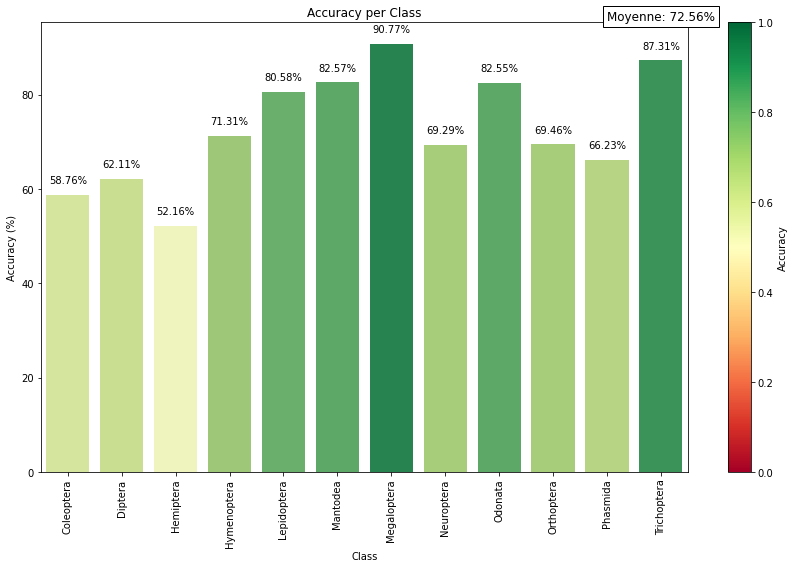

In [54]:
import seaborn as sns

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Normalize accuracies for colormap
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array([])

class_accuracy_denormalized = [acc * 100 for acc in class_accuracy]

# Load class names from the class_map file
with open(class_file, "r") as file:
    class_names = [line.strip() for line in file.readlines()]

# Attribute colors depending on accuracies value
colors = [sm.to_rgba(acc) for acc in class_accuracy]

# Create graph
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class')
plt.xticks(rotation=90) 
plt.colorbar(sm, ax=ax, label='Accuracy')

# Add accuracy on top
for i, acc in enumerate(class_accuracy_denormalized):
    ax.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom')

# Add mean accuracy
plt.text(len(class_names) - 1, max(class_accuracy_denormalized) + 5, f'Moyenne: {accuracy[0] * 100:.2f}%', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.savefig('results/accuracy_per_class.png')
plt.show()


### Calculate mean f1 score

Another interesting metric is the mean f1 score.

In [56]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_stats(conf_mat):
    # Counting true positives, false positives, true negatives, and false negatives
    true_positives = np.diag(conf_mat)
    false_positives = np.sum(conf_mat, axis=1) - true_positives
    false_negatives = np.sum(conf_mat, axis=0) - true_positives
    true_negatives = np.sum(conf_mat) - true_positives - false_positives - false_negatives
    # F1 Score
    f1_score = np.where((true_positives + false_positives + false_negatives) > 0, 2 * true_positives / (2 * true_positives + false_positives + false_negatives), 0)
    return f1_score, true_positives, false_positives, false_negatives, true_negatives

conf_mat = confusion_matrix(label_names_list, predictions_list)

f1_score, true_positives, false_positives, false_negatives, true_negatives = confusion_matrix_stats(conf_mat)

f1_score_mean = np.mean(f1_score[:])

print(f"f1_score_mean: {f1_score_mean}")

f1_score_mean: 0.7231203788817809


 We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [1]:
del overlay
del dpu

NameError: name 'overlay' is not defined

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----